In [1]:
%load_ext autoreload
%autoreload 2
import sys
from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

2024-04-29 11:05:46,223 | INFO     |: info
2024-04-29 11:05:46,223 | WARNING  |: warning
2024-04-29 11:05:46,227 | ERROR    |: error
2024-04-29 11:05:46,227 | CRITICAL |: critical


In [2]:
ble = get_ble_controller() # Get ArtemisBLEController object
ble.connect() # Connect to the Artemis Device

2024-04-29 11:05:46,950 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c1:6d:24:4b
2024-04-29 11:05:51,494 | INFO     |: Connected to c0:89:c1:6d:24:4b


C:\Users\xyx07\Fast_Robot\Webpage\FR-2024\code\Lab7\PID\base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [3]:
ble.send_command(CMD.ECHO, "HiHello")
output1 = ble.receive_string(ble.uuid['RX_STRING'])
print(output1)

Robot says: HiHello :)


In [19]:
ble.send_command(CMD.MOVE, "50|50")

In [20]:
ble.send_command(CMD.MOVE, "0|0")

In [6]:
raw_message=[]
#add more arrays if needed
num = []
timeToF = [] #in seconds
distanceF = [] 
distanceS = [] 
error = []
PIDoutput = []
timePID = []
def clear_data():
    # Clear all the sensor data arrays
    distanceF.clear()
    distanceS.clear()
    timeToF.clear()
    error.clear()
    PIDoutput.clear()
    timePID.clear()

def notification_handler(uuid, byte_array):
    global distanceF,distanceS,timeToF,error,PIDoutput,timePID
    raw_message.append(byte_array)
    message = ble.bytearray_to_string(byte_array)
    if message=='ToF data received.':
        print(message)
        isPID = True
    elif message=='PID data received.':
        print(message)
    else:
        readings = message.split('|')
        num.clear()
        for reading in readings:
            label, value = reading.split(':')
            num.append(float(value))
        if len(num)==3:
            if label=="Side Distance":
                timeToF.append(num[0]/1000)
                distanceF.append(num[1])
                distanceS.append(num[2])
            elif label=="PID output":
                timePID.append(num[0]/1000)
                error.append(num[1])
                PIDoutput.append(num[2])

In [225]:
Kp = 0.06
Ki = 0.00009
Kd = 8
minPWM = 50
maxPWM = 100
maxESum = int(5/Ki)
distance = 304
cmd = str(Kp)+"|"+str(Ki)+"|"+str(Kd)+"|"+str(minPWM)+"|"+str(maxPWM)+"|"+str(maxESum)
print(cmd)
ble.send_command(CMD.SET_LINEAR_PID, cmd)
ble.send_command(CMD.SET_DISTANCE, str(distance))

0.06|9e-05|8|50|100|55555


In [226]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [227]:
clear_data()
ble.send_command(CMD.LINEAR_PID, "10000")

ToF data received.


In [218]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [219]:
print(f"It takes: {round(timePID[-1]-timePID[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timePID)/(timePID[-1]-timePID[0]),2)} samples/s.")

It takes: 9.95s to collect data.
Sample rate is about 426.33 samples/s.


In [220]:
print(f"It takes: {round(timeToF[-1]-timeToF[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeToF)/(timeToF[-1]-timeToF[0]),2)} samples/s.")

It takes: 9.928s to collect data.
Sample rate is about 9.97 samples/s.


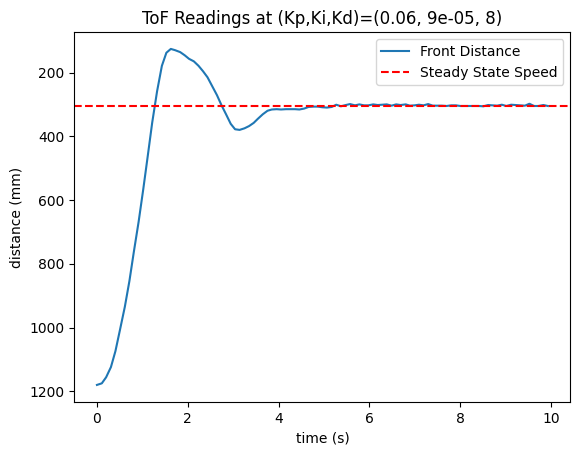

In [228]:
plt.plot(np.array(timeToF)-timeToF[0], distanceF, label = 'Front Distance')
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title("ToF Readings at (Kp,Ki,Kd)=("+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.gca().invert_yaxis()
plt.axhline(y=distance,ls='--',color='r',label='Steady State Speed')
plt.legend();

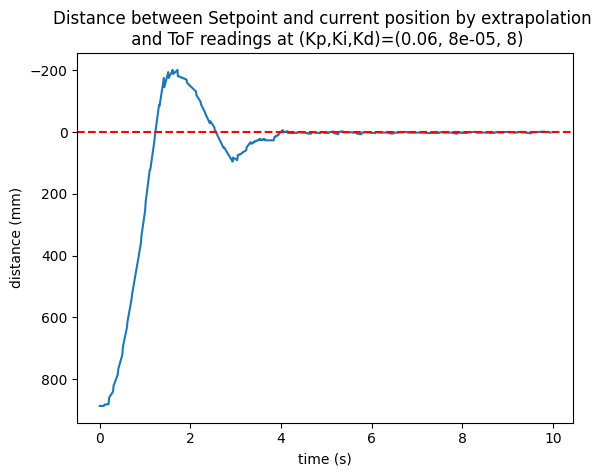

In [222]:
plt.plot(np.array(timePID)-timePID[0], error)
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title("Distance between Setpoint and current position by extrapolation \n and ToF readings at (Kp,Ki,Kd)=("+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.gca().invert_yaxis()
plt.axhline(y=0,ls='--',color='r');

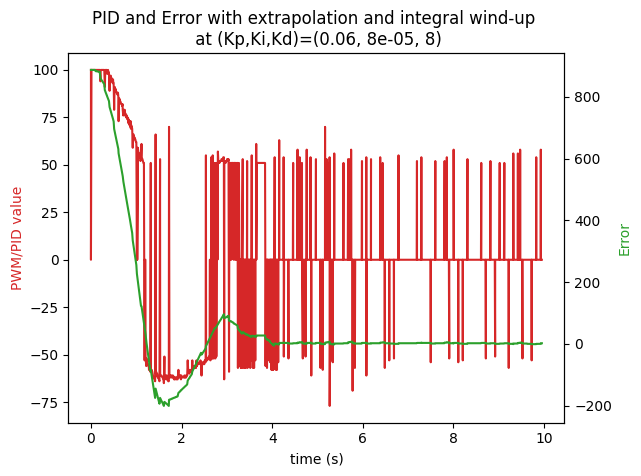

In [223]:
fig, ax1 = plt.subplots() 
color = 'tab:red'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('PWM/PID value', color = color) 
ax1.plot(np.array(timePID)-timePID[0],PIDoutput, label = 'PID', color = color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('Error', color = color) 
ax2.plot(np.array(timePID)-timePID[0],error, label = 'error', color = color)
plt.title('PID and Error with extrapolation and integral wind-up \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.show();

In [224]:
data1 = {
    "Time": timeToF,
    "DistanceF": distanceF,
    "DistanceS": distanceS
}
data2 = {
    "Time": timePID,
    "Distance": error,
    "PID": PIDoutput
}

# The filename for the CSV
csv_filename1 = 'ToF3.csv'
csv_filename2 = 'PID3.csv'

with open(csv_filename1, mode='w') as file:
    file.write(','.join(data1.keys()) + '\n')
    for i in range(len(data1["Time"])):
        file.write(f'{data1["Time"][i]},{data1["DistanceF"][i]},{data1["DistanceS"][i]}\n')

with open(csv_filename2, mode='w') as file:
    file.write(','.join(data2.keys()) + '\n')
    for i in range(len(data2["Time"])):
        file.write(f'{data2["Time"][i]},{data2["Distance"][i]},{data2["PID"][i]}\n')

In [ ]:
plt.plot(np.array(timeToF)-timeToF[0], distanceF, label = 'Front Distance')
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title('ToF Readings with extrapolation and integral wind-up \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
#plt.ylim([200,600])
plt.gca().invert_yaxis()
plt.legend();

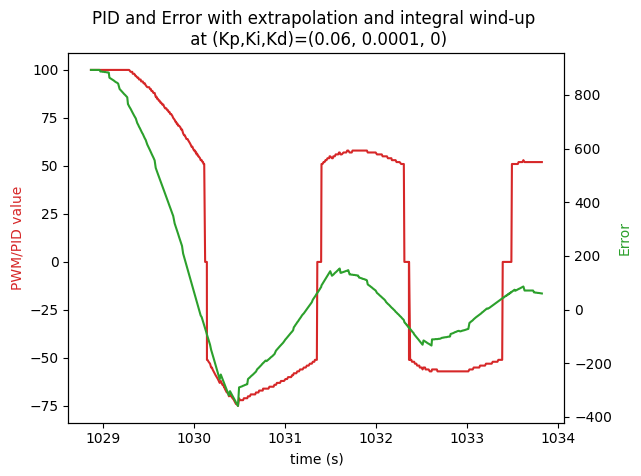

In [48]:
fig, ax1 = plt.subplots() 
color = 'tab:red'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('PWM/PID value', color = color) 
ax1.plot(timePID,PIDoutput, label = 'PID', color = color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('Error', color = color) 
ax2.plot(timePID,error, label = 'error', color = color)
plt.title('PID and Error with extrapolation and integral wind-up \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.show();

In [34]:
s=38
c= str(s)+"|"+str(s/1.12)
ble.send_command(CMD.MOVE, c)

In [7]:
int(1.2)

1

In [35]:
ble.send_command(CMD.MOVE, "0|0")

In [28]:
#Difference between consecutive time elements
samplingPeriod = [x - timeToF[i - 1] for i, x in enumerate(timeToF)][1:]
avg_samplingPeriod = np.mean(samplingPeriod) #in seconds
print(f"The sampling frequency is about {round(1/avg_samplingPeriod,3)} Hz")

The sampling frequency is about 9.804 Hz


In [10]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [11]:
# Disconnect
ble.disconnect()

2024-03-13 14:52:20,047 | INFO     |: Disconnected from C0:89:C1:6D:24:4B


In [128]:
0.000005

5e-06

##### 467+(467.0-468.0)/(27.817-27.722)/1000*299

In [30]:
str(0.015)

'0.015'